## Hyperparameter tuning via Optuna for Binary MLP model

### Being a binary model this notebook will be limited to predicting one class 1 or 0, yes or no.
### Here I will be predicting if a cell received a treatment or not

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

sys.path.append("..")
from MLP_utils.parameters import Parameters


from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

from utils.utils import df_stats
from MLP_utils.utils import parameter_set
from configparser import ConfigParser

In [2]:
# Import Data
# set data file path under pathlib path for multi-system use
file_path = Path(
    "../../Extracted_Features_(CSV_files)/interstellar_wave3_sc_norm_fs_cellprofiler.csv.gz"
)
df = pd.read_csv(
    file_path,
    low_memory=False,
)

In [3]:
config = ConfigParser()
config.optionxform = str
config.read("MLP_utils/config.ini")


params = Parameters()

params = parameter_set(params, config)
# int(params.DATA_SUBSET_NUMBER)

In [4]:
# Combine treatment with dosage to be able to discern treatments with different doses as a different condition
# Combine treatment and dose
df = df.assign(
    Metadata_Treatment_and_Dose=lambda x: df["Metadata_treatment"]
    + "_"
    + df["Metadata_dose"]
)

# df["Metadata_treatment"] = df["Metadata_treatment"] + "_" + df["Metadata_dose"]
print(df["Metadata_Treatment_and_Dose"].unique())

# Generate df speceific to analysis and model
df = df.query(
    "Metadata_Treatment_and_Dose == 'LPS_10µg/ml'| Metadata_Treatment_and_Dose == 'Media only_0'"
)
print(df["Metadata_Treatment_and_Dose"].unique())

df_stats(df)
# Drop na and reindex accordingly
df = df.dropna()
df = df.reset_index(drop=True)

# Check for Nans again
df_stats(df)
# Understand categorical data such as treatment and dosing
df[["Metadata_Treatment_and_Dose"]].drop_duplicates()
print(params.DATA_SUBSET_OPTION)
print(params.DATA_SUBSET_NUMBER)
if params.DATA_SUBSET_OPTION:
    df = df.sample(n=params.DATA_SUBSET_NUMBER)
else:
    pass

# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

['LPS_10µg/ml' 'Disulfiram_2.5µM' 'LPS_1µg/ml' 'Disulfiram_0.1µM'
 'H2O2_500µM' 'Thapsi_10µM' 'H2O2_50µM' 'Thapsi_1µM' 'ATP_1mM'
 'LPS + Nigericin_1µg/ml + 10µM' 'ATP_0.1mM'
 'LPS + Nigericin_1µg/ml + 1µM' 'Flagellin_1µg/ml' 'DMSO 0.1%_0'
 'Flagellin_0.1µg/ml' 'Media only_0']
['LPS_10µg/ml' 'Media only_0']
The dimensions of the data are: (36718, 569)
Number of total missing values across all columns: 470
The dimensions of the data are: (36589, 569)
Number of total missing values across all columns: 0
False
1500


 ### Setting up data for network training

In [5]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["Metadata_Treatment_and_Dose"] = le.fit_transform(
    df_descriptive["Metadata_Treatment_and_Dose"]
)
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop("Metadata_Treatment_and_Dose", axis=1)
df_values_Y = df_values["Metadata_Treatment_and_Dose"]

df_values_X.head()

X_train, X_test, X_val, Y_train, Y_test, Y_val = data_split(
    X_vals=df_values_X,
    y_vals=df_values_Y,
    train_proportion=0.8,
    val_proportion=0.1,
    test_proportion=0.1,
    seed=1,
)

In [6]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

IN_FEATURES = X_train.shape[1]
print("Number of in features: ", IN_FEATURES)
OUT_FEATURES = len(df_values["Metadata_Treatment_and_Dose"].unique()) - 1
print("Number of out features: ", OUT_FEATURES)

Number of in features:  555
Number of out features:  1


In [7]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=params.BATCH_SIZE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=params.BATCH_SIZE
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=params.BATCH_SIZE
)

In [8]:
# wrap the objective function inside of a lambda function to pass args...
objective_lambda_func = lambda trial: objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=trial,
    in_features=IN_FEATURES,
    out_features=OUT_FEATURES,
    params=params,
    metric=params.METRIC,
    return_info=False,
)
# Study is the object for model optimization
study = optuna.create_study(direction=f"{params.DIRECTION}")
# Here I apply the optimize function of the study to the objective function
# This optimizes each parameter specified to be optimized from the defined search space
study.optimize(objective_lambda_func, n_trials=params.N_TRIALS)
# Prints out the best trial's optimized parameters
objective_model_optimizer(
    train_loader,
    valid_loader,
    trial=study.best_trial,
    in_features=IN_FEATURES,
    out_features=OUT_FEATURES,
    params=params,
    metric=params.METRIC,
    return_info=True,
)

[I 2023-03-29 20:46:40,578] A new study created in memory with name: no-name-25c06434-613a-4802-a37e-8c4521054042
[I 2023-03-29 20:46:42,829] Trial 0 finished with value: 49.26666666666666 and parameters: {'n_layers': 2, 'n_units_l0': 9, 'dropout_0': 0.22936032762270334, 'n_units_l1': 7, 'dropout_1': 0.21887535290901847, 'learning_rate': 0.025830641792117526, 'optimizer': 'SGD'}. Best is trial 0 with value: 49.26666666666666.
[I 2023-03-29 20:46:43,443] Trial 1 finished with value: 69.37333333333332 and parameters: {'n_layers': 2, 'n_units_l0': 2, 'dropout_0': 0.34870511748156147, 'n_units_l1': 2, 'dropout_1': 0.286878745830918, 'learning_rate': 0.057369737908750544, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 69.37333333333332.
[I 2023-03-29 20:46:44,129] Trial 2 finished with value: 74.50666666666667 and parameters: {'n_layers': 2, 'n_units_l0': 7, 'dropout_0': 0.17847900723180635, 'n_units_l1': 10, 'dropout_1': 0.2368617810624217, 'learning_rate': 0.0266805310982577, 'optim

Validation Accuracy: 74.05333333333334
Validation Loss: 0.8122829830646515
Training Accuracy: 84.98666666666666
Training Loss: 0.25865924708545207


In [9]:
optuna.visualization.plot_optimization_history(study)

In [10]:
optuna.visualization.plot_intermediate_values(study)

In [11]:
# call function for best trial parameter extraction
param_dict = extract_best_trial_params(study.best_params)

In [12]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    IN_FEATURES,
    OUT_FEATURES,
    param_dict,
    params,
)
# create a DataFrame of each stat
training_stats = pd.DataFrame(
    zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
    columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
)

Adam
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.017695626795198725
    maximize: False
    weight_decay: 0
)
Epoch 0: Validation loss decreased (inf --> 0.560359).  Saving model ...
	 Train_Loss: 0.7184 Train_Acc: 48.167 Val_Loss: 0.5604  BEST VAL Loss: 0.5604  Val_Acc: 70.667

Epoch 1: Validation loss decreased (0.560359 --> 0.554253).  Saving model ...
	 Train_Loss: 0.6716 Train_Acc: 62.167 Val_Loss: 0.5543  BEST VAL Loss: 0.5543  Val_Acc: 73.333

Epoch 2: Validation loss decreased (0.554253 --> 0.547326).  Saving model ...
	 Train_Loss: 0.6338 Train_Acc: 65.333 Val_Loss: 0.5473  BEST VAL Loss: 0.5473  Val_Acc: 72.667

Epoch 3: Validation loss decreased (0.547326 --> 0.542268).  Saving model ...
	 Train_Loss: 0.6083 Train_Acc: 68.250 Val_Loss: 0.5423  BEST VAL Loss: 0.5423  Val_Acc: 73.333

Epoch 4: Validation loss decreased (0.542268 --> 0.539848).  Saving model ...
	 Train_Loss: 0.5883 Train_A

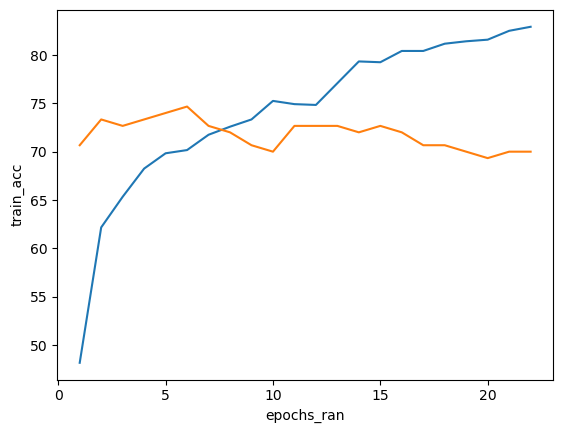

In [13]:
plot_metric_vs_epoch(training_stats, "epochs_ran", "train_acc", "valid_acc")

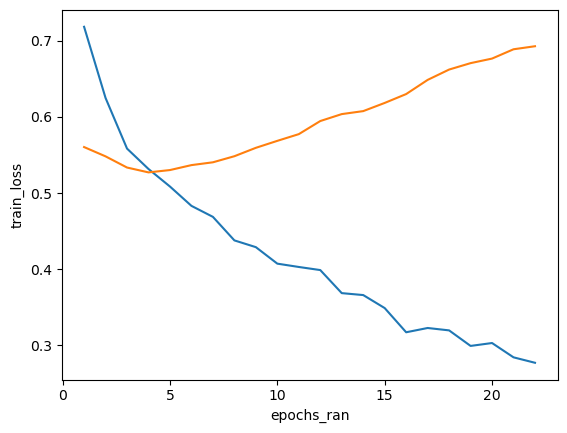

In [14]:
plot_metric_vs_epoch(training_stats, "epochs_ran", "train_loss", "valid_loss")

In [15]:
# calling the testing function and outputing list values of tested model
y_pred_list, y_pred_prob_list = test_optimized_model(
    model, test_loader, IN_FEATURES, OUT_FEATURES, param_dict, params
)

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

              precision    recall  f1-score   support

           0       0.60      0.74      0.67        70
           1       0.72      0.57      0.64        80

    accuracy                           0.65       150
   macro avg       0.66      0.66      0.65       150
weighted avg       0.67      0.65      0.65       150



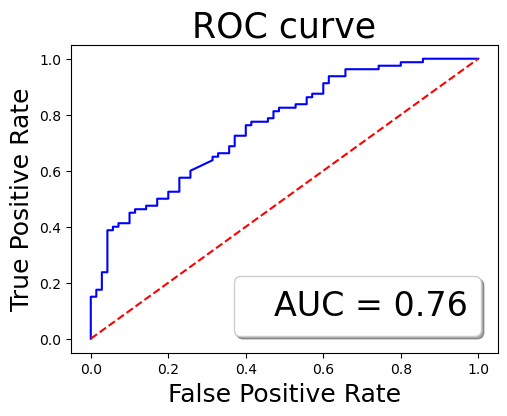

In [16]:
# Call visualization function
results_output(y_pred_list, y_pred_prob_list, Y_test)